In [1]:
import numpy as np
import cupy as cp
import opticaldevicelib_1d as od_1d
import matplotlib.pyplot as plt
# od_1d.OpticalDevice.init_values(new_dx=1e-9, new_Nx=2**20, gpu_use=True)
od_1d.OpticalDevice.init_values(new_dx=5e-8, new_Nx=2**10, gpu_use=True)
# od_1d.OpticalDevice.init_values(new_dx=5e-9, new_Nx=2**16, gpu_use=True)
# od_1d.OpticalDevice.init_values(new_dx=0.325e-6, new_Nx=2**10, gpu_use=True)
print(f"мера поля X = {od_1d.OpticalDevice.Nx * od_1d.OpticalDevice.dx * 1e6} мкм")

GPU is available!
мера поля X = 51.199999999999996 мкм


In [2]:
"""Инициализация точечного источника"""
p = od_1d.PointSource(z=15, x0=0, En=12) 
E_ps1 = np.ones_like(p.E())
# E_ps1 = p.E() / p.E()


"""Параметры СПЛ"""
N_gl = 26
Copy_flag = True
A = 50e-6
R = 6.25e-6
# R = 6e-6
# R = A ** 2 / (8 * 50e-6)
d = 2e-6
mol = "Si"
dens = 2.33


# h = od_1d.CRLhole(z=0, arr_start=E_ps1, R=R, A=A, d=d, N_lens=1, mol=mol, dens=dens, copy=Copy_flag, lam=p.lam, x0=0)
# E_ps1 = h.E()

"""Инициализация СПЛ"""
crl_ideal = od_1d.CRL(lam=p.lam, arr_start=E_ps1, z=0, R=R, A=A, d=d, N_lens=N_gl, mol=mol, dens=dens)

crl_eq = od_1d.CRLeq(lam=p.lam, arr_start=E_ps1, z=0, R=R, A=A, d=d, N_lens=N_gl, mol=mol, dens=dens,\
                     copy=Copy_flag, dist=-1e-7, is_dist_const=False)

crl_eq2 = od_1d.CRLeq(lam=p.lam, arr_start=E_ps1, z=0, R=R, A=A, d=d, N_lens=N_gl, mol=mol, dens=dens,\
                     copy=Copy_flag, dist=1e-7, is_dist_const=False)

crl_curv = od_1d.CRLcurv(lam=p.lam, arr_start=E_ps1, z=0, R=R, A=A, d=d, N_lens=N_gl, mol=mol, dens=dens,\
                     copy=Copy_flag, ex=0.99)

# crl_m =  od_1d.CRLm(lam=p.lam, arr_start=E_ps1, z=0, R=6.25e-6, A=50e-6, d=2e-6, N_lens=26, mol='Si', dens=2.33,\
#                      copy=Copy_flag, sigma=1e-6, height=0.1e-6, height_c=0.06e-6, shift=3.5e-6)

crl_m =  od_1d.CRLm(lam=p.lam, arr_start=E_ps1, z=0, R=6.25e-6, A=50e-6, d=2e-6, N_lens=26, mol='Si', dens=2.33,\
                     copy=Copy_flag, sigma=1.2e-6, height=0.1e-6, height_c=-0.35e-6, shift=3.2e-6)

# """Сеттер расстояния от линзы до экрана z_0"""
focus = crl_ideal.focus()
# z_0 = focus
# crl_ideal.set_z(z=z_0)
# crl_eq.set_z(z=z_0)
# crl_curv.set_z(z=z_0)

print(f"фокусное расстояние = {focus * 1e3 :.3f} мм")
# print(f'эксцентриситет = {crl_curv.ex}')
# print(f"оценка макс. числа линз = {int(crl_curv.Lc() * np.pi / 2)}")

фокусное расстояние = 34.634 мм


(-4.5, 4.5)

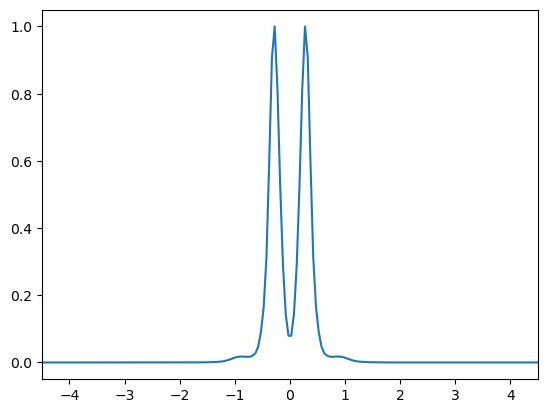

In [3]:
crl_m.set_z(z=34e-3)
filt = crl_m.I().get()
filt = filt / np.max(filt)
plt.plot(p.x.get()*1e6, filt)
plt.xlim(-4.5, 4.5)

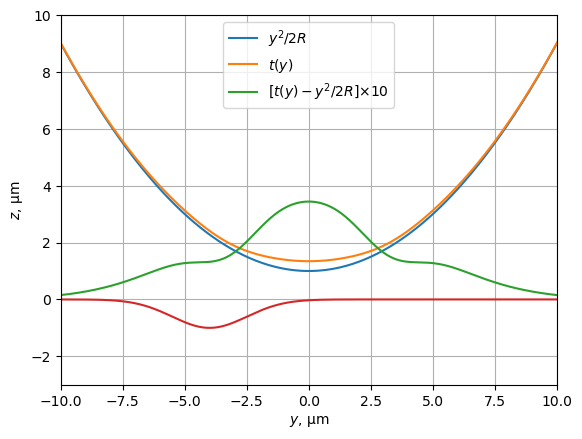

In [4]:
# %matplotlib widget
"""Построение профиля поверхности СПЛ"""
# I_prop = abs(crl.image_prop(z0=5, z1=focus, N_lens=N_gl)) ** 2
T_ideal = crl_ideal.T().get() * 1e6
T_curv = crl_curv.T().get() * 1e6
T_eq = crl_eq.T().get() * 1e6
T_m = crl_m.T().get() * 1e6 
xxx = p.x.get()*1e6


def norm_pdf(x, sig, mean, coef):
    # coef = 1/(sig*cp.sqrt(2*cp.pi))
    # coef = 0.1
    return -coef * cp.exp(-(x-mean)**2/(2*sig**2)) + 1


arr_gauss = norm_pdf(p.x, sig=3e-6, mean=0, coef=0.4).get() 

# plt.plot(p.x.get()*1e6, ( crl_ideal.T() / crl_ideal.toplogy()).get(), label='parabola / T(x)')


plt.plot(xxx, T_ideal, label=r"${y}^2/2R$")
plt.plot(xxx, T_m, label=r"$t(y)$")
# plt.plot(p.x.get()*1e6, arr_gauss*10, label='mult. by this gaussian')

plt.plot(xxx, (T_m - T_ideal)*10, label=r"$[t(y)-{y}^2/2R$]×10")
plt.plot(xxx, -np.exp(-(xxx+4)**2/(2*(1.5)**2)))

# plt.plot(p.x.get()*1e6, dif_curv  , label="ellips")
# plt.plot(p.x.get()*1e6, , label="eq")
# plt.plot(p.x.get()*1e6, crl_curv.T().get(), label='ellips')
# plt.plot(p.x.get()*1e6, crl_eq.T().get(), label='equidist')
# plt.plot(p.x.get()*1e6, h.T().get(), label='equidist')
plt.legend()
# plt.yscale("log")
plt.xlabel("$y$, μm")
plt.ylabel("$z$, μm");
plt.grid()
plt.ylim(-3, 10)
plt.xlim(-10, 10);

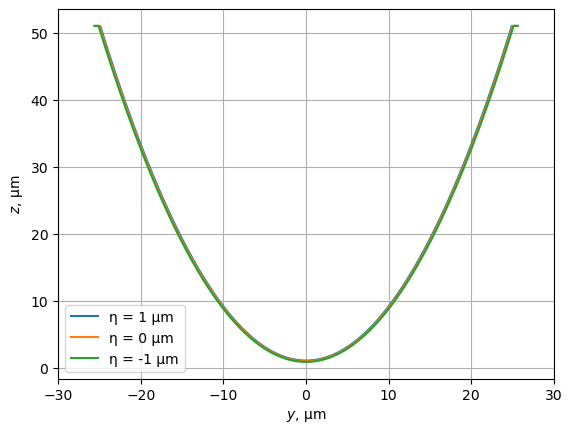

In [5]:
# %matplotlib widget
"""Построение профиля поверхности СПЛ"""
# I_prop = abs(crl.image_prop(z0=5, z1=focus, N_lens=N_gl)) ** 2
T_ideal = crl_ideal.T().get() * 1e6
T_curv = crl_curv.T().get() * 1e6
T_eq = crl_eq.T().get() * 1e6
T_eq2 = crl_eq2.T().get() * 1e6
T_m = crl_m.T().get() * 1e6 
xxx = p.x.get()*1e6

plt.plot(xxx, T_eq2, label="η = 1 μm")
plt.plot(xxx, T_ideal, label="η = 0 μm")
plt.plot(xxx, T_eq, label="η = -1 μm")
# plt.plot(xxx, (T_m - T_ideal)*100, label="diff (x100)")

# plt.plot(p.x.get()*1e6, dif_curv  , label="ellips")
# plt.plot(p.x.get()*1e6, , label="eq")
# plt.plot(p.x.get()*1e6, crl_curv.T().get(), label='ellips')
# plt.plot(p.x.get()*1e6, crl_eq.T().get(), label='equidist')
# plt.plot(p.x.get()*1e6, h.T().get(), label='equidist')
plt.legend()
# plt.yscale("log")
plt.xlabel("$y$, μm")
plt.ylabel("$z$, μm");
plt.grid()
# plt.ylim(-0.5, 10)
plt.xlim(-30, 30);

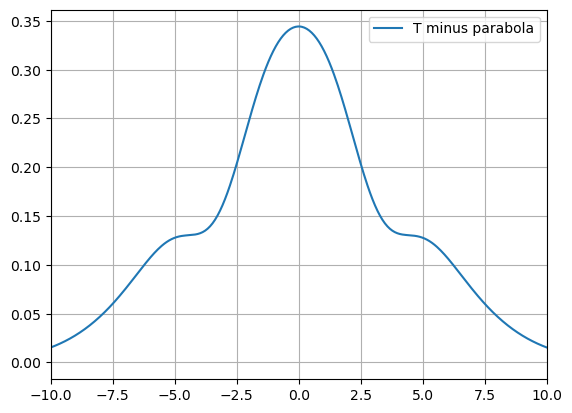

In [12]:
def norm_pdf(x, sig, mean, coef):
    # coef = 1/(sig*cp.sqrt(2*cp.pi))
    # coef = 0.1
    return -coef * cp.exp(-(x-mean)**2/(2*sig**2)) + 1


arr_gauss = norm_pdf(p.x, sig=2.5e-6, mean=0, coef=0.45).get() 

# plt.plot(p.x.get()*1e6, ( crl_ideal.T() / crl_ideal.toplogy()).get(), label='parabola / T(x)')
# plt.plot(p.x.get()*1e6, arr_gauss, label='mult. by this gaussian')
plt.plot(xxx, (T_m - T_ideal), label='T minus parabola')
plt.plot()
plt.xlim(-10, 10)
# plt.ylim(-10e-6, 10e-6)
plt.legend()
plt.grid()

 dz = 28.45608315212178 mm 
 dx = 0.0 μm 
 fwhm = 1.716860803038789 μm 
 I_max = 23.475415111237815 rel. un. 
 div_ang = 4.706519144015431e-05


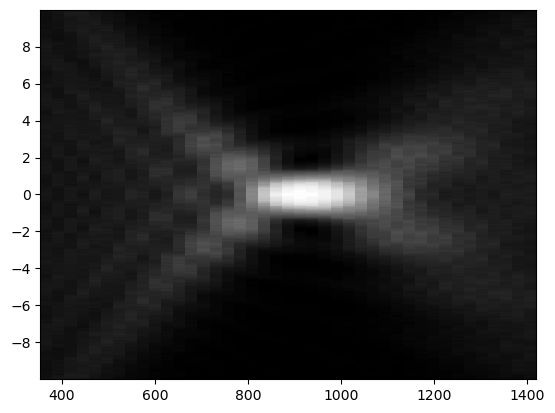

In [17]:
"""Точечный источник"""
z_arr = np.arange(14, 55, 1) * 1e-3 * 26
# z_arr = np.array([focus])
I_distr_max, I_max, dz_max_1, dx_max, fwhm, focus_images, z_arr, div_ang, x_cutted\
     = crl_m.focus_params(z_arr, T_arr=cp.array(T_m)*1e-6, n_cut=int(20e-6/od_1d.OpticalDevice.dx), focus=34e-3)

print(f" dz = {(5e-2+dz_max_1*1e-3-crl_m.focus())*1e3} mm \n dx = {dx_max} μm \n fwhm = {fwhm*1e6} μm \n I_max = {I_max} rel. un. \n div_ang = {div_ang}")
I_sum_dot = abs(focus_images)**2
I_sum_dot = I_sum_dot.get()

plt.pcolormesh(z_arr*1e3+2, x_cutted*1e6, I_sum_dot.T, cmap="Greys_r")
plt.ylim(-10, 10)
# plt.xticks(np.arange((z_arr*1e3+2)[0], (z_arr*1e3+2)[-1]+4, step=4))
plt.yticks(np.arange(-8, 8+2, step=2));

In [14]:
z_arr.shape

(41,)

In [13]:
crl_ideal = od_1d.CRL(lam=p.lam, arr_start=E_ps1, z=0, R=R, A=A, d=d, N_lens=N_gl, mol=mol, dens=dens)

crl_m =  od_1d.CRLm(lam=p.lam, arr_start=E_ps1, z=0, R=6.25e-6, A=50e-6, d=2e-6, N_lens=26, mol='Si', dens=2.33,\
                     copy=Copy_flag, sigma=1.2e-6, height=0.1e-6, height_c=-0.35e-6, shift=3.2e-6)

In [58]:
"Протяженный источник"
crl_m.set_z(z=focus)
I_arr_test = crl_m.I()
z_arr = np.arange(14, 55, 2) * 1e-3 + 2e-3

N_source_x = 21
size_source_x = cp.linspace(-2e-4, 2e-4, N_source_x)


def gauss_1d(x, sig):
    return np.exp(-0.5*(x/sig)**2)

gauss_test = cp.zeros(shape=(N_source_x))

sig = 1.17e-4/2.355

# sh1, sh2 = I_arr_test.shape
sh_z = len(z_arr)
I_sum = cp.zeros(shape=I_sum_dot.shape)
I_sum_ideal = cp.zeros(shape=I_sum_dot.shape)

# phase_sum = cp.zeros(shape=(sh_z, int(20e-6/od_2d.OpticalDevice.dy)*2, int(20e-6/od_2d.OpticalDevice.dx)*2))
# phase_sum_ideal = cp.zeros(shape=(sh_z, int(20e-6/od_2d.OpticalDevice.dy)*2, int(20e-6/od_2d.OpticalDevice.dx)*2))

# t_loop = crl_global.T()
t_loop = cp.array(T_m) * 1e-6

for j, x0 in enumerate(size_source_x):
    p_loop = od_1d.PointSource(En=12, z=15, x0=x0)
    E_p_loop = p_loop.E()

    crl_loop = od_1d.CRLm(lam=p_loop.lam, arr_start=E_p_loop, z=0, R=6.25e-6, A=50e-6, d=2e-6, N_lens=26, mol='Si', dens=2.33,\
                     copy=Copy_flag, sigma=1.2e-6, height=0.1e-6, height_c=-0.35e-6, shift=3.2e-6)

    crl_loop_ideal = od_1d.CRL(lam=p.lam, arr_start=E_p_loop, z=0, \
            R=6.25e-6, A=50e-6, d=2e-6, N_lens=N_gl, mol="Si", dens=2.33)

    gauss_test[j] = gauss_1d(x0, sig)
        
    I_distr_max, I_max, dz_max_1, dx_max, fwhm, focus_images, z_arr, div_ang, x_cutted\
        = crl_loop.focus_params(z_arr, T_arr=t_loop, n_cut=int(20e-6/od_1d.OpticalDevice.dx), focus=34e-3)
    I_sum += abs(focus_images)**2 * gauss_test[j] / N_source_x

    I_distr_max, I_max, dz_max_1, dx_max, fwhm, focus_images, z_arr, div_ang, x_cutted\
        = crl_loop_ideal.focus_params(z_arr, n_cut=int(20e-6/od_1d.OpticalDevice.dx), focus=34e-3)
    I_sum_ideal += abs(focus_images)**2 * gauss_test[j] / N_source_x

I_sum = I_sum.get()
I_sum_ideal = I_sum_ideal.get()

100%|██████████| 25/25 [00:00<00:00, 1125.01it/s]


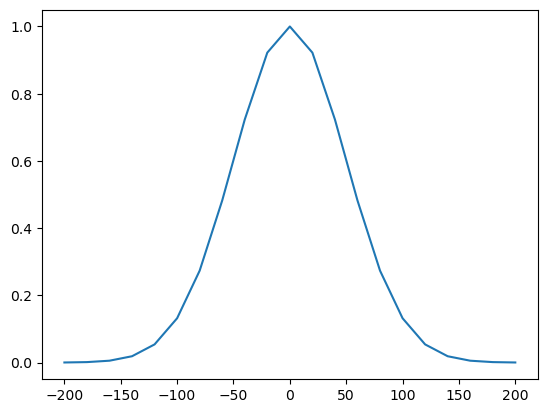

In [56]:
plt.plot(size_source_x.get()*1e6, gauss_test.get())

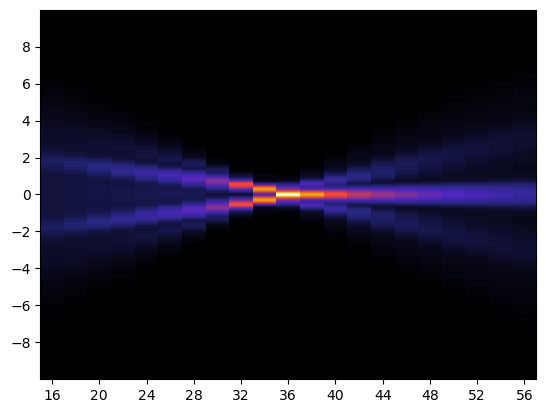

In [65]:
plt.pcolormesh(z_arr*1e3, x_cutted*1e6, I_sum.T, cmap="CMRmap")
plt.ylim(-10, 10)
plt.xticks(np.arange((z_arr*1e3)[0], (z_arr*1e3)[-1]+4, step=4))
plt.yticks(np.arange(-8, 8+2, step=2));

NameError: name 'X' is not defined

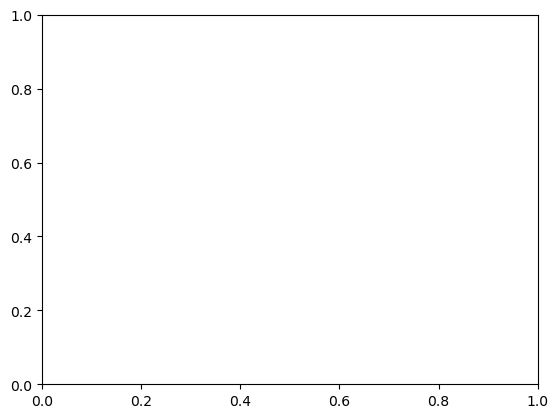

In [65]:
fig1,ax1 = plt.subplots(1, 1)
# fig1.set_figheight(15)
# fig1.set_figwidth(15)
colbar = plt.pcolormesh(X, Y, np.gradient(I_arr, axis=0, edge_order=2), cmap='inferno')
cbar = fig1.colorbar(colbar)
cbar.set_label('$I$, a.u.')

# plt.title("Intensity distribution at the focus (an ideal CRL)")
# plt.axvline(x = 0, color = 'g', alpha=0.8, linewidth=0.5)
# plt.plot([x_cutted[0]*1e6, x_cutted[-1]*1e6], [focus*1e3, focus*1e3], 'g', alpha=0.8, linewidth=0.5)
# plt.plot([(dx_max*1e-6 - fwhm/2)*1e6, (dx_max*1e-6 + fwhm/2)*1e6], [(dz_max*1e-3 + focus)*1e3, (dz_max*1e-3 + focus)*1e3], marker='|', color="blue", linewidth=0.5)
# plt.xlim(-2, 2)
plt.xlabel("$x$, μm")
plt.ylabel("$z$, mm");
# plt.savefig("1mkm", dp

In [ ]:
fig1,ax1 = plt.subplots(1, 1)
# fig1.set_figheight(15)
# fig1.set_figwidth(15)
colbar = plt.pcolormesh(X, Y, np.angle(Z), cmap='inferno')
cbar = fig1.colorbar(colbar)
cbar.set_label('$I$, a.u.')

# plt.title("Intensity distribution at the focus (an ideal CRL)")
# plt.axvline(x = 0, color = 'g', alpha=0.8, linewidth=0.5)
# plt.plot([x_cutted[0]*1e6, x_cutted[-1]*1e6], [focus*1e3, focus*1e3], 'g', alpha=0.8, linewidth=0.5)
# plt.plot([(dx_max*1e-6 - fwhm/2)*1e6, (dx_max*1e-6 + fwhm/2)*1e6], [(dz_max*1e-3 + focus)*1e3, (dz_max*1e-3 + focus)*1e3], marker='|', color="blue", linewidth=0.5)
# plt.xlim(-2, 2)
plt.xlabel("$x$, μm")
plt.ylabel("$z$, mm");
# plt.savefig("1mkm", dp

In [ ]:

fig1,ax1 = plt.subplots(1, 1)
# fig1.set_figheight(15)
# fig1.set_figwidth(15)
for i, line in enumerate(Z.T):
    Z[i] = np.gradient(line)
colbar = plt.pcolormesh(X, Y, Z, cmap='inferno')
cbar = fig1.colorbar(colbar)
cbar.set_label('$I$, a.u.')

# plt.title("Intensity distribution at the focus (an ideal CRL)")
# plt.axvline(x = 0, color = 'g', alpha=0.8, linewidth=0.5)
# plt.plot([x_cutted[0]*1e6, x_cutted[-1]*1e6], [focus*1e3, focus*1e3], 'g', alpha=0.8, linewidth=0.5)
# plt.plot([(dx_max*1e-6 - fwhm/2)*1e6, (dx_max*1e-6 + fwhm/2)*1e6], [(dz_max*1e-3 + focus)*1e3, (dz_max*1e-3 + focus)*1e3], marker='|', color="blue", linewidth=0.5)
# plt.xlim(-2, 2)
plt.xlabel("$x$, μm")
plt.ylabel("$z$, mm");
# plt.savefig("1mkm", dp

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# # Создаем пример данных
# x = np.linspace(0, 10, 100)
# y = np.linspace(0, 10, 100)
# X, Y = np.meshgrid(x, y)
# Z1 = np.sin(X) * np.cos(Y)  # первая матрица
# Z2 = np.cos(X) * np.sin(Y)  # вторая матрица

# Создаем фигуру и оси
fig, ax = plt.subplots()

# Добавляем первое pcolormesh
# pc1 = ax.pcolormesh(X, Y, abs(Z), cmap='Blues', shading='auto', alpha=0.5)
# Добавляем второе pcolormesh
pc2 = ax.pcolormesh(X, Y, np.angle(Z)-np.angle(Z_ideal), cmap='Reds', shading='auto', alpha=0.5)

# Добавляем цветовые полоски
fig.colorbar(pc1, ax=ax, label='Значения Z1')
fig.colorbar(pc2, ax=ax, label='Значения Z2')

# Убираем оси
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
# ax.set_title('Две полупрозрачные карты с разными цветовыми шкалами')

# Показать график
plt.show()

In [66]:
"""Подсчет распр. I для протяженного источника"""
N_source = 201
# X_s = cp.linspace(-100e-6, 100e-6, N_source)
X_s = cp.linspace(0, 100e-6, N_source//2+1)
X_s = np.concatenate((-X_s[::-1][:-1], X_s), axis=None)
n_dots = 21
n_cut = int(32e-6/od_1d.OpticalDevice.dx)

image_sum = cp.zeros(shape=(n_dots, n_cut*2))

def norm_pdf(x, sig, mean):
    coef = 1/(sig*cp.sqrt(2*cp.pi))
    return coef * cp.exp(-(x-mean)**2/(2*sig**2))

w = norm_pdf(X_s, 100e-6/2.355, cp.mean(X_s))

# def norm_pdf(x, sig, mean):
#     return sig / np.pi / ((x-mean)**2 + sig**2)

# w = norm_pdf(X_s, 3e-4, cp.mean(X_s))




focus = crl_ideal.focus()

for i, x_s in enumerate(X_s):
    p_loop = od_1d.PointSource(z=15, x0=x_s, En=12)
    E_p_loop = p_loop.E() # плоская волна

    # h = od_1d.Hole(x0=0, y0=0, R=25e-6, arr_start=E_p_loop, z=0, lam=p.lam)

    # E_p_loop = h.E()

    # h = od_1d.CRLhole(z=0, arr_start=E_p_loop, R=R, A=A, d=d, N_lens=1, mol=mol, dens=dens, copy=Copy_flag, lam=p.lam, x0=0)
    # E_ps1 = h.E()
    # E_p_loop = h.E()

    # crl_loop = od_1d.CRLcurv(lam=p_loop.lam, arr_start=E_p_loop, z=0, \
    #                 R=6.25e-6, A=50e-6, d=2e-6, N_lens=N_gl, mol="Si", dens=2.33, \
    #                 copy=Copy_flag, ex=0.99)
    
    # crl_loop = od_1d.CRLeq(lam=p_loop.lam, arr_start=E_p_loop , z=0, \
    #             R=6.25e-6, A=50e-6, d=2e-6, N_lens=N_gl, mol="Si", dens=2.33, \
    #             copy=Copy_flag, dist=-0e-7, is_dist_const=True)

    crl_loop = od_1d.CRLm(lam=p_loop.lam, arr_start=E_p_loop, z=0, R=6.25e-6, A=50e-6, d=2e-6, N_lens=26, mol='Si', dens=2.33,\
                     copy=Copy_flag, sigma=2e-6, height=0.2e-6, shift=3.5e-6)
    
    # crl_loop = od_1d.CRL(lam=p_loop.lam, arr_start=E_p_loop, z=0, R=6.25e-6, A=50e-6, d=2e-6, N_lens=26, mol='Si', dens=2.33)
    
    crl_loop.set_z(z=focus)
    I_distr_max, I_max, dz_max, dx_max, fwhm, focus_image, z_arr, div_ang, x_cutted = crl_loop.focus_params(n_dots=n_dots-1, eps=20e-3, n_cut=n_cut, focus=34e-3)
    # image_sum  += abs(focus_image)**2
    image_sum  += abs(focus_image)**2 * w[i]
    # image_sum  += focus_image
image_sum  = image_sum / len(X_s) / I_max

TypeError: CRL.focus_params() got an unexpected keyword argument 'n_dots'

31999


100%|██████████| 25/25 [00:00<00:00, 1029.05it/s]


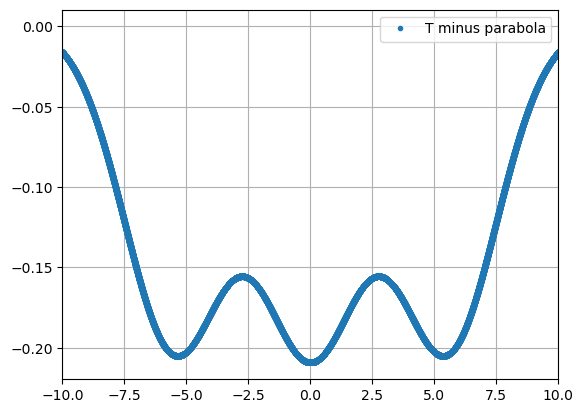

In [15]:
n_dots = 21
n_cut = int(32e-6/od_1d.OpticalDevice.dx)
# n_cut = 65535
print(n_cut)
p_loop = od_1d.PointSource(z=13, x0=0, En=12)
# E_p_loop = np.ones_like(p_loop.E())  # плоская волна
E_p_loop = p_loop.E()
# E_pp = od_1d.PhasePlate(lam=p_loop.lam, arr_start=E_p_loop, z=0, R=6.25e-6, A=50e-6, d=2e-6, N_lens=1, mol='Si', dens=2.33,\
#                      copy=Copy_flag, shift=0e-6, sigma=3e-6, height=0.4).E()


crl_loop = od_1d.CRLm(lam=p_loop.lam, arr_start=E_p_loop, z=0, R=6.25e-6, A=50e-6, d=2e-6, N_lens=26, mol='Si', dens=2.33,\
                     copy=Copy_flag, sigma=2e-6, height=0.2e-6, shift=5.5e-6)

# crl_loop = od_1d.CRLeq(lam=p_loop.lam, arr_start=E_p_loop, z=0, R=6.25e-6, A=50e-6, d=2e-6, N_lens=26, mol='Si', dens=2.33,\
#                      copy=Copy_flag, dist=-1e-6, is_dist_const=False)

# crl_loop = od_1d.CRL(lam=p_loop.lam, arr_start=E_p_loop, z=0, R=6.25e-6, A=50e-6, d=2e-6, N_lens=26, mol='Si', dens=2.33)

I_distr_max, I_max, dz_max, dx_max, fwhm, focus_image, z_arr, div_ang, x_cutted = crl_loop.focus_params(n_dots=n_dots-1, eps=20e-3, n_cut=n_cut, focus=34e-3)


plt.plot(xxx, (crl_loop.T().get()*1e6 - T_ideal), '.', label='T minus parabola')
plt.plot()
plt.xlim(-10, 10)
# plt.ylim(-10, 10)
plt.legend()
plt.grid()

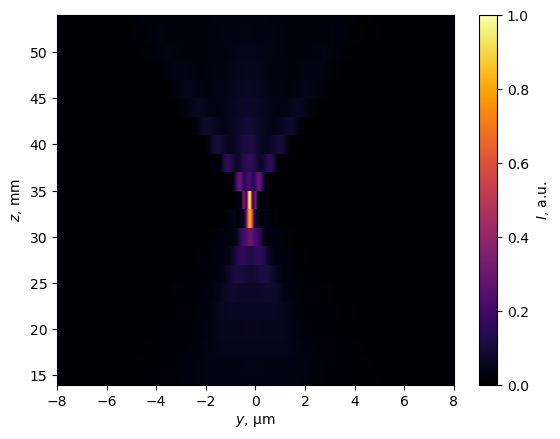

In [19]:
"""Построение распр. I для протяженного источника"""
X, Y = np.meshgrid(x_cutted*1e6, z_arr*1e3)
fig1,ax1 = plt.subplots(1, 1)
# result = image_sum.get() / np.max(image_sum.get())
result = abs(focus_image.get())**2
result = result / np.max(result)
# result = result
colbar = plt.pcolormesh(X, Y, result, vmax=np.max(result), cmap='inferno')
cbar = fig1.colorbar(colbar)
cbar.set_label('$I$, a.u.')

# plt.title("Intensity distribution at the focus (an ideal CRL)")
# plt.axvline(x = 0, color = 'g', alpha=0.8, linewidth=0.5)
# plt.plot([x_cutted[0]*1e6, x_cutted[-1]*1e6], [focus*1e3, focus*1e3], 'g', alpha=0.8, linewidth=0.5)
# plt.plot([(dx_max*1e-6 - fwhm/2)*1e6, (dx_max*1e-6 + fwhm/2)*1e6], [(dz_max*1e-3 + focus)*1e3, (dz_max*1e-3 + focus)*1e3], marker='|', color="blue", linewidth=0.5)
plt.ylim(14, 54)
plt.xlim(-8, 8)
plt.xlabel("$y$, μm")
plt.ylabel("$z$, mm");

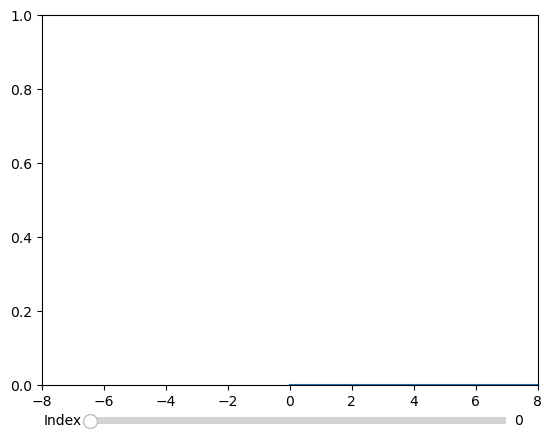

In [12]:
# %matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# Создаем массив данных (можно использовать свои данные)
# data = focus_images[np.max(np.where(z_arr-focus_2d<-1.5e-3))].T
data = result
# Создаем начальный график по индексу 0
fig, ax = plt.subplots()
l, = ax.plot(data[0])
ax.set_ylim(0, np.max(data))
ax.set_xlim(x_cutted[0], x_cutted[-1])
ax.set_xlim(-8, 8)
# Создаем слайдер
axcolor = 'lightgoldenrodyellow'
slider_ax = plt.axes([0.2, 0.02, 0.65, 0.03], facecolor=axcolor)
slider = Slider(slider_ax, 'Index', 0, len(data)-1, valinit=0, valstep=1)

# Функция обновления графика по индексу
def update(val):
    index = int(slider.val)
    l.set_ydata(data[index])
    l.set_xdata(x_cutted*1e6)
    ax.set_title("$z$ = "+ f"{(z_arr[index]*1e3):.2f} mm")
    plt.draw()

slider.on_changed(update)

plt.show()

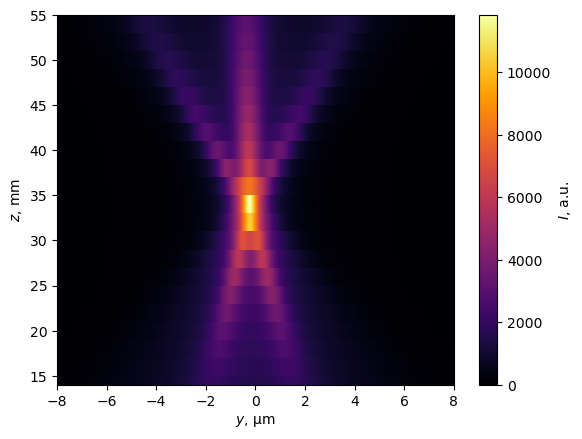

In [15]:
"""Гаусс-фильтр распр. I для протяженного источника"""
Z_filterd = od_1d.OpticalDevice.gauss_filter_2d(arr=result, x=x_cutted, sig_x=3e-7, core='lorentz')
# Z_filterd = (Z_filterd.real)/np.max(Z_filterd.real)
# Z_filterd = (Z_filterd.real)
# max_filtered = np.max(Z_filterd)
X, Y = np.meshgrid(x_cutted*1e6, z_arr*1000)
fig1,ax1 = plt.subplots(1, 1)
colbar = plt.pcolormesh(X, Y, -Z_filterd/np.max(Z_filterd), cmap='inferno', )
cbar = fig1.colorbar(colbar)
cbar.set_label('$I$, a.u.')

# plt.title("Intensity distribution at the focus (an ideal CRL)")
# plt.axvline(x = 0, color = 'g', alpha=0.8, linewidth=0.5)
# plt.plot([x_cutted[0]*1e6, x_cutted[-1]*1e6], [focus*1e3, focus*1e3], 'g', alpha=0.8, linewidth=0.5)
# plt.plot([(dx_max*1e-6 - fwhm/2)*1e6, (dx_max*1e-6 + fwhm/2)*1e6], [(dz_max*1e-3 + focus)*1e3, (dz_max*1e-3 + focus)*1e3], marker='|', color="blue", linewidth=0.5)
plt.xlim(-8, 8)
plt.ylim(14, 55)
plt.xlabel("$y$, μm")
plt.ylabel("$z$, mm");

In [16]:
Z_filterd

array([[-7.58680629e-07, -7.66561314e-07, -7.74442208e-07, ...,
         7.35039916e-07,  7.42919928e-07,  7.50800173e-07],
       [-8.80702722e-07, -8.88791676e-07, -8.96880938e-07, ...,
         8.56437940e-07,  8.64525819e-07,  8.72614080e-07],
       [-1.01186782e-06, -1.02019967e-06, -1.02853207e-06, ...,
         9.86875510e-07,  9.95205743e-07,  1.00353651e-06],
       ...,
       [-6.62455293e-06, -6.64115033e-06, -6.65772265e-06, ...,
         6.57461064e-06,  6.59128305e-06,  6.60793049e-06],
       [-6.26705711e-06, -6.28252716e-06, -6.29797714e-06, ...,
         6.22052739e-06,  6.23605715e-06,  6.25156709e-06],
       [-5.97120600e-06, -5.98568303e-06, -6.00014397e-06, ...,
         5.92767867e-06,  5.94220381e-06,  5.95671295e-06]])

In [19]:
def read_res(folder, model_name):
    I_ftian = np.load(f"{folder}/{model_name}/data.npy")
    deconv = np.load(f"{folder}/{model_name}/deconv.npy")
    y_cut = np.load(f"{folder}/{model_name}/y_cut.npy")
    z_arr = np.load(f"{folder}/{model_name}/z_arr.npy")
    
    return I_ftian, deconv, y_cut, z_arr

I_ftian, deconv, y_cut, z_ftian = read_res("ftian_cache", "2d_res")

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# Создаем массив данных (можно использовать свои данные)
# data = focus_images[np.max(np.where(z_arr-focus_2d<-1.5e-3))].T
# data = Z_filterd
# Создаем начальный график по индексу 0
fig, ax = plt.subplots()
l, = ax.plot(y_cut, I_ftian[0], label='experiment')
l2, = ax.plot(y_cut, deconv[0], '-', label='deconv')
l3, = ax.plot((x_cutted)*1e6, Z_filterd[0] / np.max(Z_filterd), label='model conv lorenz 1 mkm')
l4, = ax.plot((x_cutted)*1e6,  result[0] / np.max(result), label='model ext source (gauss 100 mkm)')
plt.legend()
ax.set_ylim(-0.2, 1)
# ax.set_xlim(x_cutted[0], x_cutted[-1])
ax.set_xlim(-8, 8)
# Создаем слайдер
axcolor = 'lightgoldenrodyellow'
plt.axhline(y = 0.5, color = 'g', alpha=0.8, linewidth=0.5)
# plt.grid()
slider_ax = plt.axes([0.2, 0.02, 0.65, 0.03], facecolor=axcolor)
slider = Slider(slider_ax, 'Index', 0, len(data)-1, valinit=0, valstep=1)

# Функция обновления графика по индексу
def update(val):
    index = int(slider.val)

    l.set_ydata(I_ftian[index])
    l.set_xdata(y_cut)

    l2.set_ydata(deconv[index])
    l2.set_xdata(y_cut)

    l3.set_ydata(Z_filterd[index]/ np.max(Z_filterd))
    l3.set_xdata((x_cutted)*1e6)

    l4.set_ydata(result[index] / np.max(result))
    l4.set_xdata((x_cutted)*1e6)

    ax.set_title(f"$z$ = {(z_arr[index]*1e3):.2f} mm, $Imax$ = {(np.max(data[index])):.2f}")
    
    plt.draw()

slider.on_changed(update)

plt.show()

In [ ]:
import matplotlib as mpl
mpl.rc('font',family='Times New Roman')

i = 12
print(z_arr[i]*1e3)
# plt.plot((x_cutted)*1e6, image_sum_ideal[i].get() / np.max(image_sum_ideal.get()), "-.",. label='ideal_point (x25.6e-3)')
# plt.plot((x_cutted)*1e6, image_sum_aber_point[i].get() / np.max(image_sum_ideal.get()), label='aber_point (x25.6e-3)')

plt.plot(y_cut, I_ftian[i], label='experiment')
plt.plot(y_cut,  deconv[i], '-', label='deconv')
plt.plot((x_cutted)*1e6, Z_filterd[i] / np.max(Z_filterd), label='model conv lorenz 1 mkm')
plt.plot((x_cutted)*1e6,  result[i] / np.max(result), label='model ext source (gauss 100 mkm)')

plt.legend(fontsize="10")
plt.xlim(-8, 8)
plt.ylim(-0.2, 1.02)
plt.xlabel("$y, μm$")
plt.ylabel("$I, a.u.$")
plt.show()

In [ ]:
I_ftian[i]

In [ ]:
"""Распределение I(x, z) в окрестности фокуса"""

N_frames = 15
arr_writer = np.empty(shape=(N_frames, 1001, 1400))

ex_arr = np.linspace(0.98, 1.02, N_frames)

for i, ex in enumerate(ex_arr):

    crl_curv = od_1d.CRLcurv(lam=p.lam, arr_start=E_ps1, z=0, R=R, A=A, d=d, N_lens=N_gl, mol=mol, dens=dens,\
                        copy=Copy_flag, ex=ex)

    I_distr_max, I_max, dz_max, dx_max, fwhm, focus_image, z_arr, div_ang, x_cutted = crl_curv.focus_params(n_dots=1000, eps=10e-3, n_cut=700, focus=35e-3)

    arr_writer[i] = focus_image

    
X, Y = np.meshgrid(x_cutted*1e6, z_arr*1000)
Z = arr_writer[1]
fig1,ax1 = plt.subplots(1, 1)
colbar = plt.pcolormesh(X, Y, Z, cmap='inferno')
cbar = fig1.colorbar(colbar)
cbar.set_label('$I$, a.u.')

# plt.title("Intensity distribution at the focus (an ideal CRL)")
# plt.axvline(x = 0, color = 'g', alpha=0.8, linewidth=0.5)
# plt.plot([x_cutted[0]*1e6, x_cutted[-1]*1e6], [focus*1e3, focus*1e3], 'g', alpha=0.8, linewidth=0.5)
# plt.plot([(dx_max*1e-6 - fwhm/2)*1e6, (dx_max*1e-6 + fwhm/2)*1e6], [(dz_max*1e-3 + focus)*1e3, (dz_max*1e-3 + focus)*1e3], marker='|', color="blue", linewidth=0.5)
plt.xlabel("$x$, μm")
plt.ylabel("$z$, mm");
# plt.savefig("1mkm", dpi=2400);

In [ ]:
import plotly.graph_objects as go
volume = arr_writer
xxx = x_cutted * 1e6
yyy = z_arr * 1e3
r, c = volume[0].shape
slider_arr = ex_arr

# Define frames
import plotly.graph_objects as go
nb_frames = len(volume)


layout = go.Layout(xaxis=go.layout.XAxis(
    title=go.layout.xaxis.Title(
        text='x, μm',
    )),
yaxis=go.layout.YAxis(
    title=go.layout.yaxis.Title(
        text='z, mm',
    )
))


fig = go.Figure(layout=layout, frames=[go.Frame(data=go.Heatmap(
    z=volume[k], x=xxx, y=yyy, colorscale="hot", zmin=0, zmax=np.max(volume)
    ),
    name=str(k) # you need to name the frame for the animation to behave properly
    )
    for k in range(nb_frames)])

# Add data to be displayed before animation starts
fig.add_trace(go.Heatmap(
    z=volume[0], x=xxx, y=yyy,
    colorscale="hot", zmin=0, zmax=0,
    colorbar=dict(thickness=20, ticklen=4, title="I, rel. un.")
    ))


def frame_args(duration):
    return {
            "frame": {"duration": duration},
            "mode": "immediate",
            "fromcurrent": True,
            "transition": {"duration": duration, "easing": "linear"},
        }

sliders = [
            {
                "pad": {"b": 10, "t": 60},
                "len": 0.9,
                "x": 0.1,
                "y": 0,
                "steps": [
                    {
                        "args": [[f.name], frame_args(0)],
                        "label": str("{:.4f}".format((float(slider_arr[k])))),
                        "method": "animate",
                    }
                    for k, f in enumerate(fig.frames)
                ],
            }
        ]


# Layout
fig.update_layout(
         title='Focal spot',
         width=1200,
         height=1200,
         updatemenus = [
            {
                "buttons": [
                    {
                        "args": [None, frame_args(50)],
                        "label": "&#9654;", # play symbol
                        "method": "animate",
                    },
                    {
                        "args": [[None], frame_args(0)],
                        "label": "&#9724;", # pause symbol
                        "method": "animate",
                    },
                ],
                "direction": "left",
                "pad": {"r": 10, "t": 70},
                "type": "buttons",
                "x": 0.1,
                "y": 0,
            }
         ],
         sliders=sliders
)

fig.show()

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import numpy as np

# Создаем массив данных (можно использовать свои данные)
data = Z

# Создаем начальный график по индексу 0
fig, ax = plt.subplots()
l, = ax.plot(data[0])
ax.set_ylim(0, np.max(data))
ax.set_xlim(x_cutted[0], x_cutted[-1])
# Создаем слайдер
axcolor = 'lightgoldenrodyellow'
slider_ax = plt.axes([0.2, 0.02, 0.65, 0.03], facecolor=axcolor)
slider = Slider(slider_ax, 'Index', 0, len(data)-1, valinit=0, valstep=1)

# Функция обновления графика по индексу
def update(val):
    index = int(slider.val)
    l.set_ydata(data[index])
    l.set_xdata(x_cutted)
    ax.set_title("z = "+ f"{(z_arr[index] - focus)*1e3:.3f} мм")
    plt.draw()

slider.on_changed(update)

plt.show()

Тест от энергии E и числа линз N

In [ ]:
import cupy as cp
n_cut = 100
n_dots = 100

Copy_flag = True
arr_len = 2 if Copy_flag else 2*N_gl
phases = 2*np.pi*np.random.rand(arr_len)
w_s = (np.random.rand(arr_len)-0.5)*np.pi/180*0
s_s  = (np.random.rand(arr_len)-0.5)*2e-6*0




N_arr = np.arange(1, 100, 1)
E_arr = np.arange(10, 51, 5)
N_gl = 100

result_I = list()
result_I_m = list()
result_I_i = list()

for n in N_arr:
    N_gl = n

    p = od_1d.PointSource(z=100, En=15) 
    E_ps1 = p.E()/p.E()

    
    crl = od_1d.CRL(lam=p.lam, arr_start=E_ps1, z=0,\
                    R=6.25e-6, A=50e-6, d=2e-6, N_lens=N_gl, mol="Si", dens=2.33)

    crlm = od_1d.CRLm(lam=p.lam, arr_start=E_ps1, z=0, \
                    R=6.25e-6, A=50e-6, d=2e-6, N_lens=N_gl, mol="Si", dens=2.33, \
                    copy=Copy_flag, arr_phase=phases, arr_s=s_s, arr_w=w_s, b=1e-7, m=3e8)
    
    
    crlm_minus = od_1d.CRLm(lam=p.lam, arr_start=E_ps1, z=0, \
                    R=6.25e-6, A=50e-6, d=2e-6, N_lens=N_gl, mol="Si", dens=2.33, \
                    copy=Copy_flag, arr_phase=phases, arr_s=s_s, arr_w=w_s, b=-1e-7, m=3e8)
    

    # crlm.betta = 0
    crl.betta = 0 
    # crlm_minus.betta = 0

    focus = crlm.focus()

    eps_ = focus / 2
    
    I_distr_max, I_max, dz_max, dx_max, fwhm, focus_image, z_arr, div_ang, x_cutted = crlm.focus_params(n_dots=n_dots, eps=eps_, n_cut=n_cut)
    I_distr_max_i, I_max_i, dz_max_i, dx_max_i, fwhm_i, focus_image_i, z_arr_i, div_ang_i, x_cutted = crl.focus_params(n_dots=n_dots, eps=eps_, n_cut=n_cut)
    I_distr_max_m, I_max_m, dz_max_m, dx_max_m, fwhm_m, focus_image_m, z_arr_m, div_ang_m, x_cutted = crlm_minus.focus_params(n_dots=n_dots, eps=eps_, n_cut=n_cut)

    result_I_m.append([I_max_m, dz_max_m, fwhm_m, div_ang_m])
    result_I.append([I_max, dz_max, fwhm, div_ang])
    result_I_i.append([I_max_i, dz_max_i, fwhm_i, div_ang_i])
    # cp._default_memory_pool.free_all_blocks()

res_I = np.array(result_I).T
res_I_i = np.array(result_I_i).T
res_I_m = np.array(result_I_m).T

In [ ]:
import matplotlib.pyplot as plt
number = 0
x_plot = N_arr
# x_plot = E_arr
# plt.plot(x_plot, res_I[number] / np.log(x_plot), label="параллельный слой +0.1 мкм")
plt.plot(x_plot, res_I_i[number], label="идеальная линза")
# plt.plot(x_plot, res_I_m[number] / x_plot /np.log(x_plot) , label="параллельный слой -0.1 мкм")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.grid()
# plt.xlabel("Энергия, КэВ")
# plt.plot(x_plot, np.exp(-2*crl.k*crl.betta*x_plot*crl.d))
print(crl.betta)
plt.xlabel("число линз")
plt.title(f"E = {p.En} кэв")
plt.ylabel(["пиковая интенсивность", "смещение фокуса вдоль оси z, мм", "полуширина пучка в фокусе, мкм", "угол расходимости"][number]);

In [ ]:
plt.plot(x_plot, np.log10(np.exp(x_plot**0.5)))
plt.xscale('log')
plt.yscale('log')